<a href="https://colab.research.google.com/github/ck1972/Python-Geospatial_Model1/blob/main/10a_DaresSalaam_Satellite_imagery_cropping512x512_data_augmentation_UNET_model_XAI_Model4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Mapping Building Footprints: Using Grad-CAM for Enhanced Explainability**

## Dataset
In this tutorial, we will extract the building footprint using satellite imagery and the U-Net model. We will also apply the gradient-weighted class activation mapping (Grad-CAM) technique to explain the U-Net model. Grad-CAM helps us gain insights into how the U-Net model segments the building features.
We use the Dar es Salaam dataset from OpenEarthMap, a benchmark global high-resolution land cover mapping dataset. The Dar es Salaam dataset comprises 91 images and masks (1024x1024). In this  script, we use cropped images and masks resized to 512x512


## **Organization of the Tutorial**
The video tutorial is organized as follows:
1. Environment setup and library installation
2. Preprocessing the datasets
3. Deep learning using a U-Net model
4. Gradient-weighted class activation mapping (Grad-CAM)

# Environment and Libraries
## Install and import libraries
First, we will install (if not available) and import the necesssary libraries.

In [ ]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
import tensorflow as tf
import random

# Set the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Set up environment
Mount your Google drive to access to your dataset.

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


 Next, set up your working directory.

In [ ]:
# Set the working directory
import os
os.chdir(r'/content/drive/MyDrive/Unet_models_2024/Dar_es_Salaam_Segmentation/Training/Training512x512')

## Data preprocessing
Prepare your datasets. Ensure that your datasets are sorted. That is, the image matches the mask.

In [ ]:
# Sort the training and test datasets
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(test_x))

71 20


Convert the training images and masks to numpy arrays.

In [ ]:
# Convert training image to numpy array
train_xx = np.zeros((71, 512, 512, 3))
train_yy = np.zeros((71, 512, 512, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(512, 512, 1)
  train_yy[i] = np_mask

Convert the test images and masks to numpy arrays.

In [ ]:
# Convert test images and masks to numpy array
test_xx = np.zeros((20, 512, 512, 3))
test_yy = np.zeros((20, 512, 512, 1))
for i, (img_path, mask_path) in enumerate(zip(test_x, test_y)):
    img = Image.open(img_path)
    np_img = np.array(img)
    test_xx[i] = np_img

    mask = Image.open(mask_path)
    np_mask = np.array(mask).reshape(512, 512, 1)  # Ensure mask is in the correct shape
    test_yy[i] = np_mask

Display a selected image and corresponding mask.

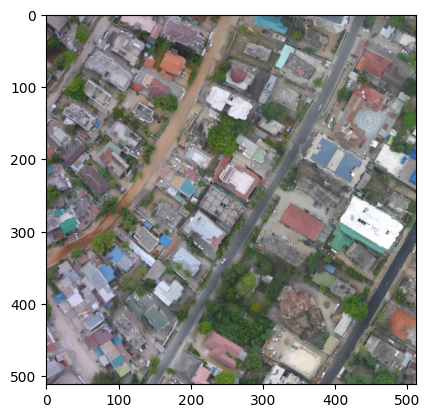

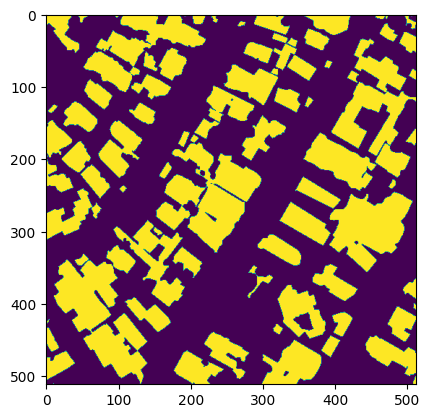

In [ ]:
# Plot a sample input RGB image and building mask
plt.imshow(train_xx[40, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[40, :, :, 0].astype('uint8'))
plt.show()

# Save to numpy format
Check the shape of the image and mask.

In [ ]:
# Check the shape
print(train_xx.shape)
print(train_yy.shape)
print(test_xx.shape)
print(test_yy.shape)

(71, 512, 512, 3)
(71, 512, 512, 1)
(20, 512, 512, 3)
(20, 512, 512, 1)


## Data augmentation
Next, we will do data augmentation.

In [ ]:
# Import the ImageDataGenerator library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup data augmentation
data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(train_xx, augment=True, seed=seed)
mask_datagen.fit(train_yy, augment=True, seed=seed)

image_generator = image_datagen.flow(train_xx, batch_size=10, seed=seed)
mask_generator = mask_datagen.flow(train_yy, batch_size=10, seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Define the U-Net model
U-Net is a semantic segmentation architecture comprising a contracting path and an expansive path. The contracting path employs two 3x3 convolutions with ReLU activation and 2x2 max pooling for downsampling, doubling feature channels at each step. The expansive path includes upsampling, a 2x2 "up-convolution" to halve feature channels, concatenation with cropped contracting path features, and two 3x3 convolutions with ReLU. Cropping compensates for border pixel loss in convolutions. The final layer uses a 1x1 convolution to map 64-component features to class outputs. The network consists of 23 convolutional layers in total

Next, prepare a code that defines and compiles a U-Net model using TensorFlow, a popular deep learning library. The U-Net model is widely used for image segmentation tasks where the goal is to classify each pixel of an image into a category.

In [ ]:
# Load the necessary packages
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (512, 512, 3)  # Adjust as per your dataset
x_in = Input(shape=input_shape)

'''Encoder'''
# Adjust dropout rates here as needed
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.1)(x_temp)  # Adjusted dropout rate
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2, 2))(x_skip1)

x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.1)(x_temp)  # Adjusted dropout rate
x_skip2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2, 2))(x_skip2)

x_temp = Conv2D(128, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.2)(x_temp)  # Adjusted dropout rate
x_skip3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2, 2))(x_skip3)

x_temp = Conv2D(256, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.2)(x_temp)  # Adjusted dropout rate
x_temp = Conv2D(256, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Dropout(0.2)(x_temp)  # Adjusted dropout rate
x_temp = Conv2D(128, (3, 3), activation='relu', padding='same')(x_temp)

x_temp = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Dropout(0.2)(x_temp)  # Adjusted dropout rate
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Dropout(0.1)(x_temp)  # Adjusted dropout rate
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)

# Final convolution
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

# Construct the model
unet_model4 = Model(inputs=x_in, outputs=x_out)
unet_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model's architecture
unet_model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['dropout[0][0]']             
                                                                                              

Next, dipslay the Unet model structure. First, ensure you have the required packages installed. You need both tensorflow (or keras) and pydot, as well as graphviz for plotting.

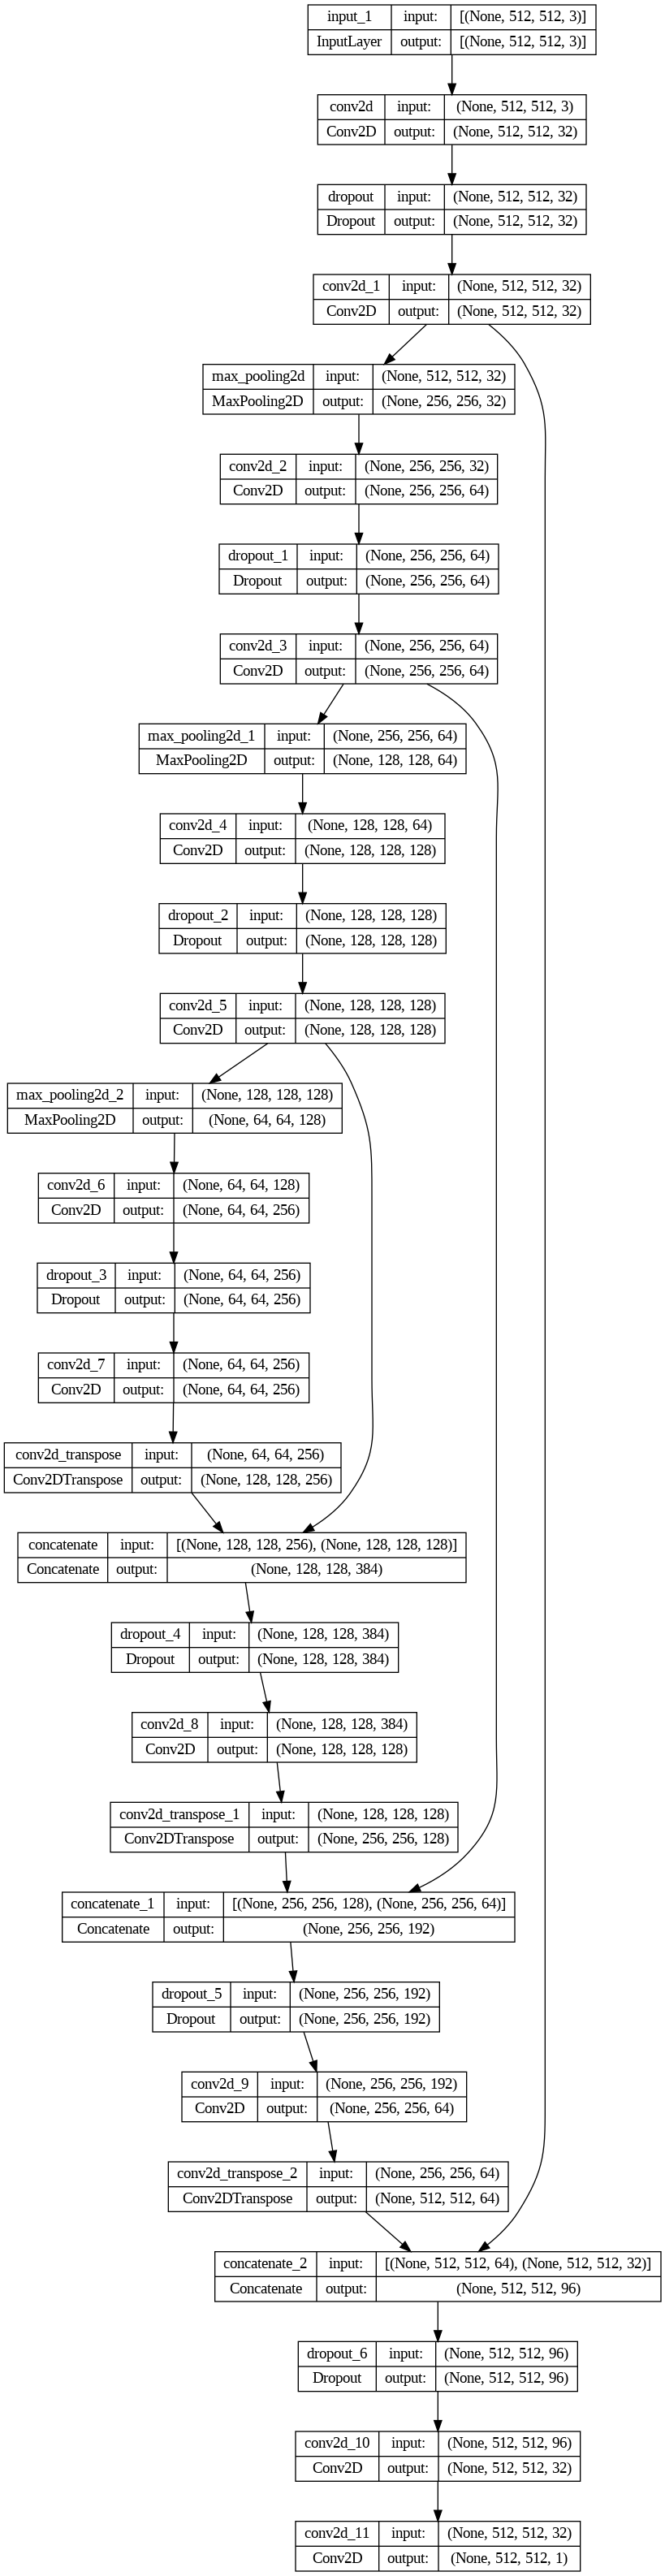

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your U-Net model
plot_model(unet_model4, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Fit the Unet model. This script will include a basic implementation of early stopping and learning rate adjustment.

In [ ]:
# Import the necessary libraries
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Setup callbacks
early_stopper = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

# Train the model
history = unet_model4.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=100, batch_size=10, callbacks=[early_stopper, reduce_lr])

Plot the loss curve to check model performance.

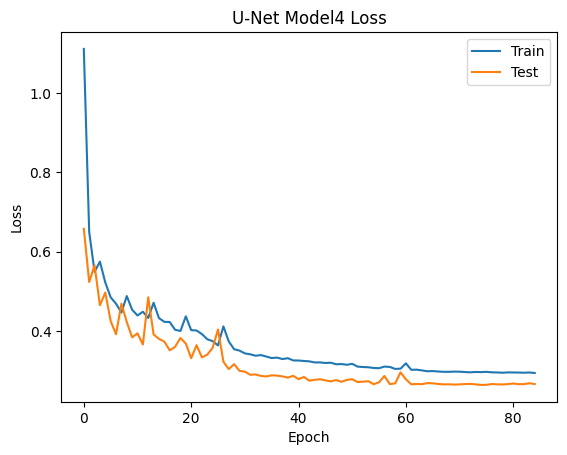

In [ ]:
# Plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('U-Net Model4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


Next, calculate the mean loss and accuracy from your U-Net model training. Then extract these values from the history object returned by model.fit(). This object contains the training and validation loss and accuracy for each epoch.

In [ ]:
# Calculate mean training loss and accuracy
mean_training_loss = sum(history.history['loss']) / len(history.history['loss'])
mean_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])

# Calculate mean validation loss and accuracy
mean_validation_loss = sum(history.history['val_loss']) / len(history.history['val_loss'])
mean_validation_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

print(f"Mean Training Loss: {mean_training_loss}")
print(f"Mean Training Accuracy: {mean_training_accuracy * 100}%")
print(f"Mean Validation Loss: {mean_validation_loss}")
print(f"Mean Validation Accuracy: {mean_validation_accuracy * 100}%")

Mean Training Loss: 0.36399826232124777
Mean Training Accuracy: 83.4704052700716%
Mean Validation Loss: 0.3185818826451021
Mean Validation Accuracy: 86.13014747114742%


Next, save the unet model.

In [ ]:
# Save the trained model
unet_model4.save('unet_model4')

## Prediction
Let's use the U-Net model to perfom prediction on a selected test images.

1/1 [==============================] - 0s 300ms/step


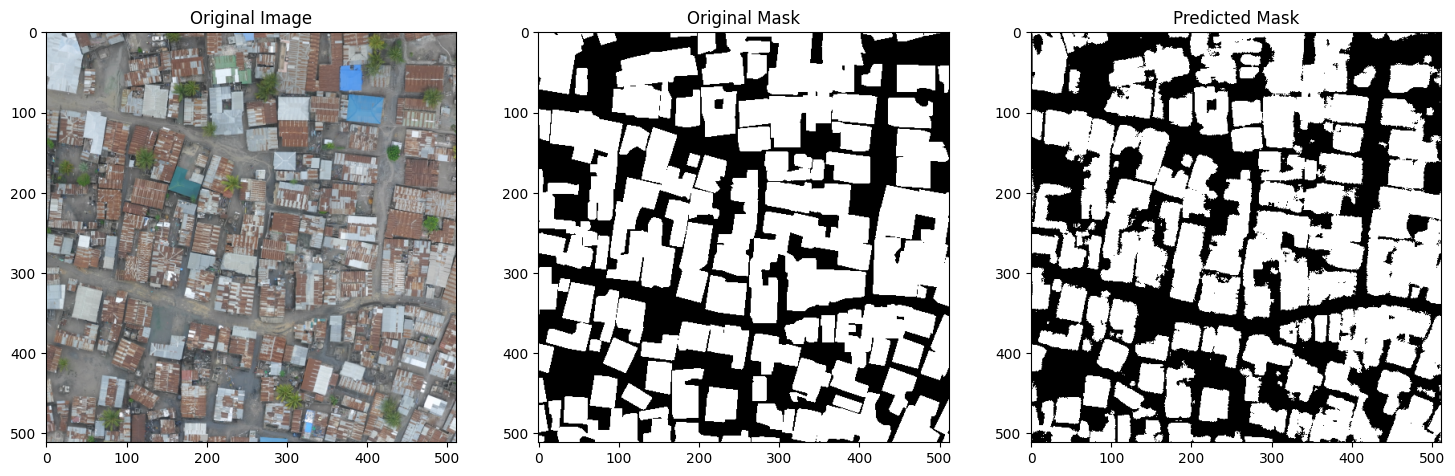

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define the threshold value for prediction
threshold = 0.5

# Load your image and its mask
image_path = '/content/drive/MyDrive/Unet_models_2024/Dar_es_Salaam_Segmentation/Training/Training512x512/test/19_image.tif'
mask_path = '/content/drive/MyDrive/Unet_models_2024/Dar_es_Salaam_Segmentation/Training/Training512x512/test/19_label.tif'
# Replace the paths above with the correct paths for the mask
test_xx = np.expand_dims(img_to_array(load_img(image_path)), axis=0)
test_yy = np.expand_dims(np.expand_dims(img_to_array(load_img(mask_path, color_mode="grayscale")), axis=-1), axis=0)

# Prediction of the output for the loaded image
pred_test = unet_model4.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)

# Display the original image, original mask, and predicted mask
# plt.figure(figsize=(12, 4))
plt.figure(figsize=(18, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(test_xx[0].astype('uint8'))  # Adjusted for single image
plt.title('Original Image')

# Original mask
plt.subplot(1, 3, 2)
plt.imshow(test_yy[0, :, :, 0], cmap='gray')  # Adjusted for single image
plt.title('Original Mask')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(pred_test[0, :, :, 0], cmap='gray')  # Adjusted for single image
plt.title('Predicted Mask')

plt.show()

## **Explainable Deep Learning using Grad-CAM**
To perform Grad-CAM, it is essential to understand the layers of the model and select an appropriate layer for visualization. Typically, Grad-CAM works best with convolutional layers that retain high-level spatial information—often a layer closer to the output that captures features relevant to the final decision.

Why intermediate activations matter
* Convolutional layers in a U-Net model progressively extract higher-level features from the input image, such as edges, textures, and complex shapes.
* By visualizing the intermediate activations, we can understand how the model perceives and processes different features within the image, step-by-step.
* Grad-CAM leverages gradients flowing into these convolutional layers to create a heatmap that highlights the parts of the input image that contribute most significantly to the model’s prediction.

### Visualizing intermediate convnet outputs (intermediate activations)
First, we inspect the U-Net model to identify the specific layers we want to use for the Grad-CAM visualization. We start by printing out all the layers in the model to understand its structure and find the appropriate layer for visualizing important features.

In [ ]:
# Print the layer names
for layer in unet_model4.layers:
    print(layer.name)

input_1
conv2d
dropout
conv2d_1
max_pooling2d
conv2d_2
dropout_1
conv2d_3
max_pooling2d_1
conv2d_4
dropout_2
conv2d_5
max_pooling2d_2
conv2d_6
dropout_3
conv2d_7
conv2d_transpose
concatenate
dropout_4
conv2d_8
conv2d_transpose_1
concatenate_1
dropout_5
conv2d_9
conv2d_transpose_2
concatenate_2
dropout_6
conv2d_10
conv2d_11


Let's create models to visualize activations. Then we load our input image and predict and visualize the activations.

##### Notes
In the above code snippet, we loop through all the layers in our U-Net model and print their names. This allows us to:
* Inspect the model architecture
It is crucial to understand how the model is constructed. By printing the layer names, we can see the order and types of layers used.
* Select the best layer for Grad-CAM
Grad-CAM typically uses the last convolutional layer before the output, as this layer retains spatial information and helps identify the regions most important for decision-making. Inspecting the layers helps us choose an appropriate one to target for visualizing model attention.

In the U-Net model, we ideally look for a convolutional layer near the output, as this layer captures the abstracted features necessary for segmentation, while still retaining sufficient spatial detail for visualization purposes.

### Grad-CAM with layer attribution and activation maps
In this section, we implement Grad-CAM to visually interpret which parts of an image influenced the U-Net model’s decision during the segmentation task. Specifically, we will be focusing on layer attribution by examining a specific convolutional layer's feature maps and using gradients to understand the importance of different regions.

The following process will allow us to generate a heatmap, indicating the parts of the image that contributed most to the model's segmentation result. This is particularly helpful in flood mapping, as it helps verify if the model correctly attends to features like water bodies or flooded regions.

Pooled Grads: [1.]
Pooled Grads: [1.]
Pooled Grads: [1.]


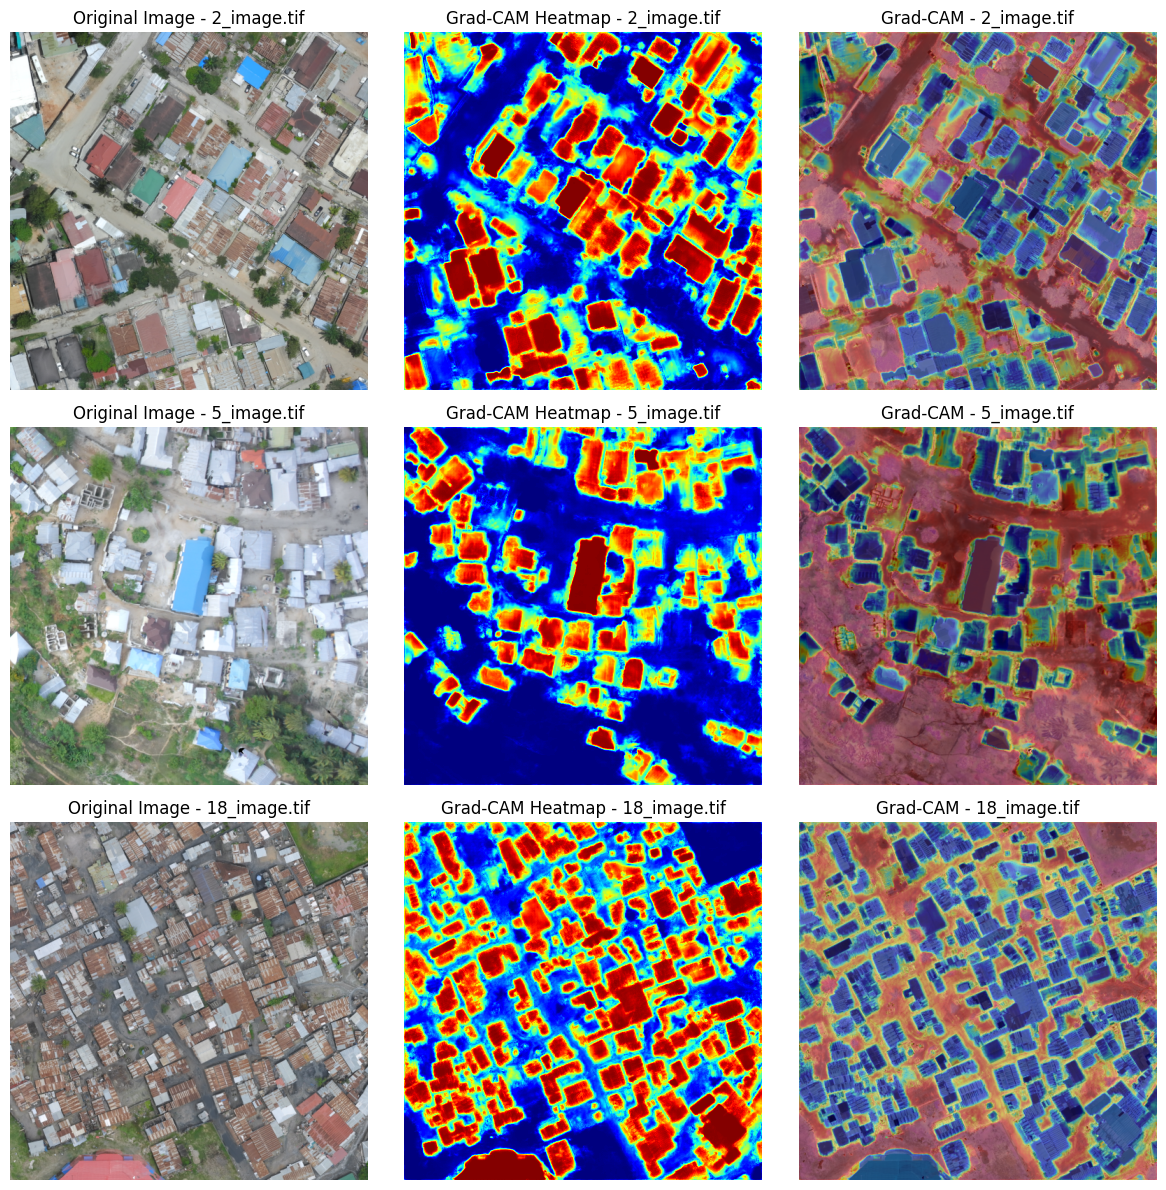

In [ ]:
# Import the necessary libraries.
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the U-Net model
model_unet = load_model('unet_model4')

def generate_layer_gradcam(model, img_array, layer_name, target_neuron_index):
    target_layer = model.get_layer(layer_name).output
    grad_cam_model = tf.keras.models.Model(inputs=model.input, outputs=[target_layer, model.output])

    with tf.GradientTape() as tape:
        last_conv_output, model_output = grad_cam_model(img_array)
        class_output = model_output[:, :, :, target_neuron_index]

    grads = tape.gradient(class_output, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print("Pooled Grads:", pooled_grads.numpy())  # Debug print

    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    raw_heatmap = np.uint8(255 * heatmap)
    raw_heatmap_resized = cv2.resize(raw_heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap_colormap = cv2.applyColorMap(raw_heatmap_resized, cv2.COLORMAP_JET)
    img_array_uint8 = np.uint8(255 * img_array[0])
    gradcam_result = cv2.addWeighted(img_array_uint8, 0.6, heatmap_colormap, 0.4, 0)

    return gradcam_result, raw_heatmap_resized

# Directory containing images
img_path = '/content/drive/MyDrive/Unet_models_2024/Dar_es_Salaam_Segmentation/Training/Training512x512/test'
image_filenames = ['2_image.tif', '5_image.tif', '18_image.tif']
full_image_paths = [os.path.join(img_path, filename) for filename in image_filenames]

plt.figure(figsize=(12, 12))

for i, file_path in enumerate(full_image_paths):
    original_img = load_img(file_path, target_size=(512, 512))
    img_array = img_to_array(original_img)
    img_array = np.expand_dims(img_array, axis=0)

    gradcam_result, raw_heatmap_resized = generate_layer_gradcam(model_unet, img_array, "conv2d_11", 0)

    plt.subplot(len(image_filenames), 3, 3 * i + 1)
    plt.imshow(original_img)
    plt.title("Original Image - " + image_filenames[i])
    plt.axis('off')

    plt.subplot(len(image_filenames), 3, 3 * i + 2)
    plt.imshow(raw_heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap - " + image_filenames[i])
    plt.axis('off')

    plt.subplot(len(image_filenames), 3, 3 * i + 3)
    plt.imshow(gradcam_result)
    plt.title("Grad-CAM - " + image_filenames[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

Data Source: https://open-earth-map.org/

Note:
The source of the Dar es salaam(Tanzania) dataset is Open Cities AI and the data provider is the Global Facility for Disaster Reduction and Recovery. The dataset is available under the CCBY4.0 license.

The U-Net model architecture was modified from: https://github.com/iamtekson/deep-learning-for-earth-observation/blob/main/Notebooks/03.%20image%20segmentation/01.%20Building%20detection/Building_Mapping.ipynb